# Using Chebyshev's inequality to detect accumulated precipitation data anomalies.
The basic idea is to gather accumulated precip data from stations near each other. Under the assumption that, stations near each other will produce similar data to each other, we can treat the accumulated precip data as a random variable with some distribution that is unknown to us. Then we can use Chebyshev's Inequality or the Markov inequality to get and upper bound for the probability that a certain data point belongs to this distribution. All we need for this is the *sample mean* and *sample variance* of our local distribution which is simple to compute.

I will break this down into steps:
1. Given a station that we think is an anomaly or not find all of its neighbors in a reasonable radius (More on choosing the radius later)
+ Compute the mean and variance of the stations neighbors excluding the station itself (More on this as well).
+ Compute the Chebyshev Inequality and obtain an upper bound for the probability of such a point.
+ Gather results based on their bound and interpret the results.

Some important things to remember:
- The distribution of a stations neighbors may also be contaminated. This is the nature of the beast. We will explore the impacts of this depending on how contaminated the distribution is.
- This method heavily relies on the assumption that observations geographically close to each other behave similarly.
- For now we will only consider the accumulated precip. It may be possible to extend this to several variables.

## Chebyshev's Inequality
Chebyshev's Inequality is used to obtain an upper bound for the probability that a certain number is outside a distance from the mean. More precisely, let $X$ be a random varaible with some distribution $D$. Let $\mu, \sigma^{2}$ be the mean and variance, respectively, of your data. Then 
$$
\begin{equation}
P(|X-\mu| \geq \epsilon) \leq \dfrac{\sigma^{2}}{\epsilon^{2}}=\delta
\end{equation}
$$
#### Our case:
In our case $x \geq 0$ and we will only consider $P(X-\mu \geq \epsilon) \leq P(|X-\mu| \geq \epsilon) \leq \dfrac{\sigma^{2}}{\epsilon^{2}}=\delta$. We can obtain $\epsilon$ by considering the concentration inequality,
$$
P(X \geq \alpha)=P(X-\mu \geq \alpha-\mu)=P(X-\mu \geq \epsilon) \leq \dfrac{\sigma^{2}}{\epsilon^{2}}=\delta, \quad \epsilon = \alpha-\mu
$$
where $\alpha$ is the point of interest. For $0<\epsilon<1$ the problem is uninteresting and we can intuitively conclude that alpha is not a bad data point because it is very close to the mean, UNLESS $\sigma > \epsilon$. If $\delta>1$ then it strongly suggests that $\alpha$ belongs to the distribution.

## Example datasets

Firstly, we need to address another assumption that makes Chebyshev's work. That is that our data is distributed approximately normal

In [39]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os.path
import requests
import json
import pandas as pd
from datetime import datetime
from pandas.io.json import json_normalize

#### Visualization function.

In [40]:
def _plot_(x):
    plt.hist(x,bins=15)
    plt.xlabel('Precip')
    plt.ylabel('Count')
    plt.title('Precip frequency')
    plt.show()
    plt.plot(x, '-o', label='Precip')
    plt.hlines(x.mean(), xmin=0, xmax=x.shape[0]-1, label='Mean')
    plt.hlines([x.mean()+x.std(), x.mean()-x.std()], xmin=0, xmax=x.shape[0]-1, 
               linestyles='dashed', label='1 Std')
    plt.xlabel('Index')
    plt.ylabel('Precip')
    plt.legend()
    plt.show()

#### Normal(5,2)

X:  [6.3315865  5.71527897 3.45459971 4.99161615 5.62133597 4.27991444
 5.26551159 5.10854853 5.00429143 4.82539979 5.43302619 6.20303737
 4.03493433 6.02827408 5.22863013] 

Mu: 5.1683990121842855, 
Var: 0.5960567787571353, 
Alpha: 0.0, 
Bound: 0.02231390407785536

Mu: 5.1683990121842855, 
Var: 0.5960567787571353, 
Alpha: 1.0, 
Bound: 0.03430433958152741

Mu: 5.1683990121842855, 
Var: 0.5960567787571353, 
Alpha: 2.0, 
Bound: 0.059375583829553207

Mu: 5.1683990121842855, 
Var: 0.5960567787571353, 
Alpha: 3.0, 
Bound: 0.12676788070744696

Mu: 5.1683990121842855, 
Var: 0.5960567787571353, 
Alpha: 4.0, 
Bound: 0.43662165266911657

Mu: 5.1683990121842855, 
Var: 0.5960567787571353, 
Alpha: 5.0, 
Bound: 21.01883070312867

Mu: 5.1683990121842855, 
Var: 0.5960567787571353, 
Alpha: 6.0, 
Bound: 0.8619015036240234

Mu: 5.1683990121842855, 
Var: 0.5960567787571353, 
Alpha: 7.0, 
Bound: 0.17767482373717897

Mu: 5.1683990121842855, 
Var: 0.5960567787571353, 
Alpha: 8.0, 
Bound: 0.07434016507107806


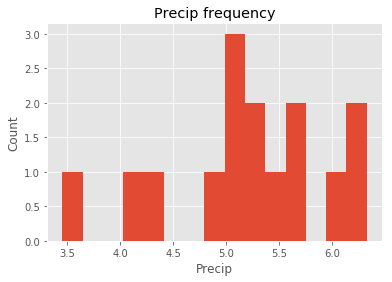

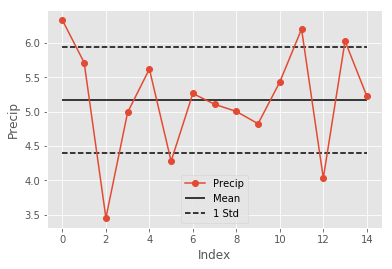

In [41]:
np.random.seed(10)
x = np.random.normal(5,1,15)
print('X: ', x, '\n')
mu = x.mean()
var = x.var()
for i in np.linspace(0,19,20):
    alpha = i
    epsilon = alpha-mu
    bound = var/(epsilon**2)

    print('Mu: {}, \nVar: {}, \nAlpha: {}, \nBound: {}\n'.format(mu,var,alpha,bound))
    
_plot_(x)

For normally distributed data the edge cases are even more unlikely. Now that we have a grasp on how the estimation behaves we can apply it to some real precip data. First we will just be observing the behavior, then we will define reasonable bounds to categorize the data points.

## Testing Chebyshev's on Real World Datasets
Using the [SynopticData API](https://synopticlabs.org/api/mesonet/reference/) we will look at real precipitation data to see how well our model preforms. We will consider some specific datasets that have outliers and some that do not.

Some helper functions for building a useful pandas dataframe out of the json response.

In [42]:
def get_query_dictionary(query_arg):
    """Creates a query dictionary with all of the parameters included in the query string.\n
    e.g. {token : 'demotoken', stid : 'NHMU', etc}.

    :param query_arg: query string to parse into dictionary
    :type query_arg: str
    :return: dictionary with query parameters
    :rtype: dict
    """
    params = query_arg.split(sep='&')

    keys = [arg.split('=')[0] for arg in params[1:] if arg]
    values = [arg.split('=')[1] for arg in params[1:] if arg]

    _dict = dict(zip(keys, values))

    if 'accum_hours' in _dict:
        _dict['accum_hours'] = _dict['accum_hours'].split(',')

    return _dict

In [43]:
def make_dataframe(query_string):
    """Constructs a dataframe from the query passed, assumes that the query is for pmode totals or last.

    :param query_string: string of the api query to make the dataframe out of
    :type query_string: str
    :return: dataframe with accumulated precip columns
    :rtype: pandas.DataFrame
    """
    resp = requests.get(query_string)

    # Any errors in the query
    assert resp.status_code == 200, "Server Error or URL Error"
    values_dict = json.loads(resp.text)
    if int(values_dict['SUMMARY']['RESPONSE_CODE']) == 2:
        print(values_dict['SUMMARY']['RESPONSE_MESSAGE'])
        return pd.DataFrame()

    assert int(values_dict['SUMMARY']['RESPONSE_CODE']) == 1, values_dict['SUMMARY']['RESPONSE_MESSAGE'] + '\n' + \
                                                              query_string
    # Success!
    df = json_normalize(values_dict['STATION'])
    # Get the arguments of the API call e.g. end, start, pmode, etc.
    query_dictionary = get_query_dictionary(query_string)

    # pmode last and intervals is not supported.
    if query_dictionary['pmode'] == 'last':
        print('pmode: last is not supported please use pmode totals using a start and end time.')
        exit(1)

    elif query_dictionary['pmode'] == 'intervals':
        print('pmode: intervals is not supported please use pmode totals using a start and end time.')
        exit(1)

    # Totals
    elif query_dictionary['pmode'] == 'totals':
        # parse the API call's start and end and compute a timedelta
        start = datetime.strptime(query_dictionary['start'], '%Y%m%d%H%M')
        end = datetime.strptime(query_dictionary['end'], '%Y%m%d%H%M')
        delta = end.timestamp() - start.timestamp()
        
        # initialize new columns to be added to the dataframe
        new_col = np.full(df.shape[0], np.nan, dtype='float64')
        new_date_col = np.full(df.shape[0], 0, dtype='int')
        new_count_col = np.full(df.shape[0], 0, dtype='int')
        
        # Unwrap the nested data
        for i, row in df.iterrows():
            if len(row['OBSERVATIONS.precipitation']) > 0:
                _dict = row['OBSERVATIONS.precipitation'][0]
                # time difference of reporting interval
                new_date_col[i] = (int(_dict['last_report']) - int(_dict['first_report']))
                # precip total
                new_col[i] = _dict['total']
                # count of obs
                new_count_col[i] = _dict['count']
        
        # Make the new columns from the unwrapped data
        df['ACCUM_' + str(int(delta/86400)).strip() + '_DAYS'] = new_col
        df['EPOCH_TIMEDELTA'] = new_date_col
        df['COUNT'] = new_count_col
        
        # filter out an observations that are not long enough
        df = df[abs(df['EPOCH_TIMEDELTA'] - delta) < .1*delta]
        
    df = df.drop(columns=['OBSERVATIONS.precipitation', 'PERIOD_OF_RECORD.start', 'PERIOD_OF_RECORD.end'])
    df = df.apply(pd.to_numeric, errors='ignore')
    return df


#### Now for the actual computation. 

First we will consider a normal precipitation dataset that likely doesn't have any precip anomalies. These datasets are determined by using trusted stations and looking at the data to make decisions on whether the data is considered okay or normal. The particular dataset that we will use is based out of San Antonio. 

Second we will consider a couple data sets from Dugway in Utah where two stations did not report any precip from January 2018 to today. It is possible that a station will not report any precip throughout the majority of the year

#### Normal dataset

In [44]:
# A api call to a 'normal' set of precip data. not normal as in distribution, but in colloquial terms. 
normal_ex = "http://api.mesowest.net/v2/stations/precip?&radius=30,-97.8,15&token=demotoken&units=english&timeformat=%s&pmode=totals&start=201809150000&end=201810150000&network=1,2,213,234,106123,225,187"

In [45]:
normal_ex_df = pd.DataFrame()

file_exist = os.path.isfile('./normal_ex.csv')

if file_exist:
    normal_ex_df = pd.read_csv('./normal_ex.csv')
else:
    print("File not found. Re-acquiring data from API. Results may vary.")
    normal_ex_df = make_dataframe(query_string=normal_ex)
    normal_ex_df.to_csv('./normal_ex.csv', index=False)
    
normal_ex_df

,DISTANCE,ELEVATION,ELEV_DEM,ID,LATITUDE,LONGITUDE,MNET_ID,NAME,RESTRICTED,STATE,STATUS,STID,TIMEZONE,ACCUM_30_DAYS,EPOCH_TIMEDELTA,COUNT
0,14.54,486,488.8,4329,30.183040,-97.679870,1,Austin-Bergstrom International Airport,False,TX,ACTIVE,KAUS,America/Chicago,3.04,2592000,977
1,8.31,597,587.3,4805,29.893610,-97.864720,1,"San Marcos, San Marcos Municipal Airport",False,TX,ACTIVE,KHYI,America/Chicago,2.93,2592000,1190
2,12.99,722,790.7,39734,30.176667,-97.874167,2,SOUTH AUSTIN RAWS,False,TX,ACTIVE,AURT2,America/Chicago,5.39,2592000,719
3,13.72,877,908.8,41685,30.083400,-98.008100,187,Driftwood 4 SSE,False,TX,ACTIVE,DRCT2,America/Chicago,5.80,2592000,2880
4,11.47,862,885.8,41686,30.141630,-97.900200,187,Manchaca 4 W,False,TX,ACTIVE,MTCT2,America/Chicago,5.01,2592000,2880
5,13.94,482,482.3,41687,30.177320,-97.688960,187,Onion Creek at Hwy 183 - Austin,False,TX,ACTIVE,ATIT2,America/Chicago,3.38,2592000,2879
6,13.13,526,541.3,41694,29.937330,-97.593000,187,Lockhart 6 NE,False,TX,ACTIVE,LRCT2,America/Chicago,2.12,2592000,2878
7,13.17,864,869.4,63148,29.939053,-98.008392,2,SAN MARCOS-WEST,False,TX,ACTIVE,SRWT2,America/Chicago,4.68,2595600,721
8,1.23,650,656.2,63149,29.998242,-97.820453,2,KYLE-EAST,False,TX,ACTIVE,KRET2,America/Chicago,3.84,2595600,721
9,13.98,588,597.1,63375,30.194930,-97.737390,225,Teri Road near Nuckols Crossing,False,TX,ACTIVE,TNCT2,America/Chicago,4.00,2592900,2877


For simplicities sake we will not request more data from the API. Instead we only consider the bound for stations near the center of our distribution. Again this is for an illustrative purpose.

The column of interest here is the ACCUM_30_DAYS, but the data will be preserved for reporting later. Another step we will take is to save this data so that our testing remains unchanged

#### Computation

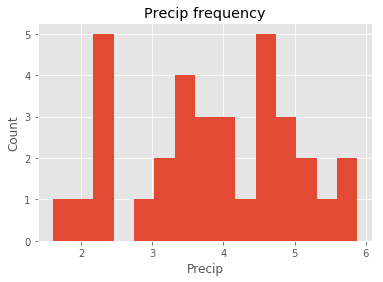

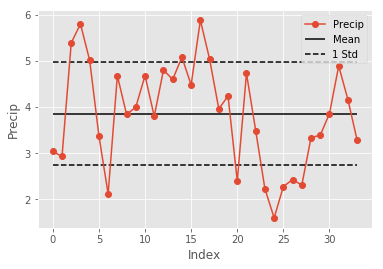

In [46]:
_plot_(normal_ex_df['ACCUM_30_DAYS'].values)

NOTE: A bound some of the lower values will not be considered in this example since they may not be spatially near the center of our dataset. 

In [47]:
# compute chebyshev bound for all stations within 6 miles of the center of our radius
# distance filter 
# TODO remove the point of interest from the mean computation to eliminate bias
norm_dist_filter = normal_ex_df['DISTANCE'] <= 6 # miles
total_precip = np.array(normal_ex_df.filter(regex='ACCUM.*'))
mu = total_precip.mean()
var = total_precip.var()
print('Mean: ', mu)
print('Variance: ', var)
print('Std Dev: ', var**.5)

norm_ex_bound_col = np.full(normal_ex_df.shape[0], np.nan, dtype='float')

for i, row in  normal_ex_df[norm_dist_filter].iterrows():
    alpha = row.filter(regex='ACCUM.*').values
    epsilon = alpha-mu
    bound = var/(epsilon**2)
    norm_ex_bound_col[i] = bound
    
# make new colum
normal_ex_df['CHEBY_BOUND'] = norm_ex_bound_col

# filter out the ones we actually computed
normal_ex_df[~normal_ex_df['CHEBY_BOUND'].isna()]

Mean:  3.857058823529411
Variance:  1.242173702422145
Std Dev:  1.1145284664027855


,DISTANCE,ELEVATION,ELEV_DEM,ID,LATITUDE,LONGITUDE,MNET_ID,NAME,RESTRICTED,STATE,STATUS,STID,TIMEZONE,ACCUM_30_DAYS,EPOCH_TIMEDELTA,COUNT,CHEBY_BOUND
8,1.23,650,656.2,63149,29.998242,-97.820453,2,KYLE-EAST,False,TX,ACTIVE,KRET2,America/Chicago,3.84,2595600,721,4268.587396
26,4.49,501,508.5,72087,29.974680,-97.730860,234,Rogers Ranch Rd,False,TX,ACTIVE,GBR09,America/Chicago,2.43,2347200,625,0.609956
28,2.59,646,656.2,72109,29.992590,-97.842410,234,Bunton Lane,False,TX,ACTIVE,GBR14,America/Chicago,3.34,2346480,625,4.646248
29,4.74,724,725.1,72110,30.029690,-97.728640,234,Engelke Rd,False,TX,ACTIVE,GBR15,America/Chicago,3.39,2346480,625,5.694285
30,5.35,778,774.3,72111,30.049290,-97.868970,234,Hays Youth Complex,False,TX,ACTIVE,GBR16,America/Chicago,3.86,2349060,625,143595.280000
32,5.75,840,853.0,72113,30.014870,-97.894530,234,Rocking M Rd,False,TX,ACTIVE,GBR18,America/Chicago,4.16,2346540,625,13.535232
33,3.92,642,652.9,72114,29.943210,-97.799130,234,FM 21 off FM 2720,False,TX,ACTIVE,GBR19,America/Chicago,3.28,2346480,624,3.730286


**Interpretation:** Now that we have computed the bounds we can see how reasonable this data set is depending on how picky we want to be on our bound. The lowest bound is about .6 which could be considered okay. The bounds of interest are the ones closer to 0.

#### Anomaly Dataset
For this demonstration we will only compute the bound for 2 known anomalies and see how their bounds behave and if they behave as expected.

In [48]:
# URLs
dugway_ex_dpg13 = "http://api.synopticlabs.org/v2/stations/precipitation?token=demotoken&radius=DPG13,15&timeformat=%s&pmode=totals&start=201803010000&end=201810140000&units=english"
dugway_ex_dpg04 = "http://api.synopticlabs.org/v2/stations/precipitation?token=demotoken&radius=DPG04,15&timeformat=%s&pmode=totals&start=201803010000&end=201810140000&units=english"

First we need to set up our data to compute. We will not walk through the setup here.

In [49]:
# Make initial dataframe
dugway_ex_dpg13_df = pd.DataFrame()
dugway_ex_dpg04_df = pd.DataFrame()

file_exist_dpg13 = os.path.isfile('./dugway_ex_dpg13.csv')
file_exist_dpg04 = os.path.isfile('./dugway_ex_dpg04.csv')

if file_exist_dpg13:
    dugway_ex_dpg13_df = pd.read_csv('./dugway_ex_dpg13.csv')
else:
    print("File not found. Re-acquiring data from API. Results may vary.")
    dugway_ex_dpg13_df = make_dataframe(query_string=dugway_ex_dpg13)
    dugway_ex_dpg13_df.to_csv('./dugway_ex_dpg13.csv', index=False)
    
if file_exist_dpg04:
    dugway_ex_dpg04_df = pd.read_csv('./dugway_ex_dpg04.csv')
else:
    print("File not found. Re-acquiring data from API. Results may vary.")
    dugway_ex_dpg04_df = make_dataframe(query_string=dugway_ex_dpg04)
    dugway_ex_dpg04_df.to_csv('./dugway_ex_dpg04.csv', index=False)

Now for the computation similar to before.

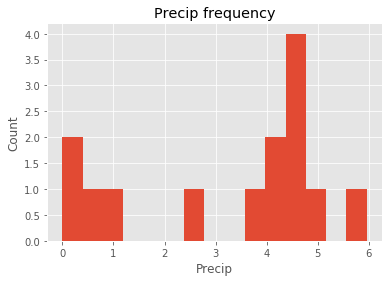

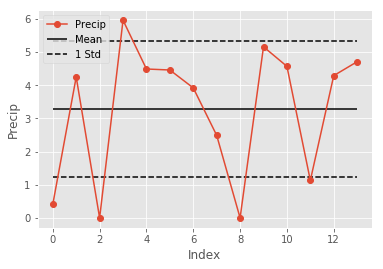

In [50]:
_plot_(dugway_ex_dpg13_df['ACCUM_226_DAYS'])

We can see the potential anomalies here. It looks there are 4, however we will only consider the ones that are 0 because we can easily assume that this is a very unlikely event.

In [51]:
# compute chebyshev bound for dpg13
# stid filter 
dpg13_filter = dugway_ex_dpg13_df['STID'] == 'DPG13'
total_precip = np.array(dugway_ex_dpg13_df.filter(regex='ACCUM.*')[~dpg13_filter])
mu = total_precip.mean()
var = total_precip.var()
print('Mean: ', mu)
print('Variance: ', var)
print('Std Dev: ', var**.5)

dugway_dpg13_bound_col = np.full(dugway_ex_dpg13_df.shape[0], np.nan, dtype='float')

for i, row in dugway_ex_dpg13_df[dpg13_filter].iterrows():
    alpha = row.filter(regex='ACCUM.*').values
    epsilon = alpha-mu
    bound = var/(epsilon**2)
    dugway_dpg13_bound_col[i] = bound
    
# make new colum
dugway_ex_dpg13_df['CHEBY_BOUND'] = dugway_dpg13_bound_col

# filter out the ones we actually computed
dugway_ex_dpg13_df[~dugway_ex_dpg13_df['CHEBY_BOUND'].isna()]

Mean:  3.5261538461538464
Variance:  3.315931360946746
Std Dev:  1.8209698956728377


,DISTANCE,ELEVATION,ELEV_DEM,ID,LATITUDE,LONGITUDE,MNET_ID,NAME,RESTRICTED,STATE,STATUS,STID,TIMEZONE,ACCUM_226_DAYS,EPOCH_TIMEDELTA,COUNT,CHEBY_BOUND
8,0.0,4538,4534.1,460,40.1067,-112.80815,3,DURAND ROAD,False,UT,ACTIVE,DPG13,America/Denver,0.0,19613100,62747,0.266688


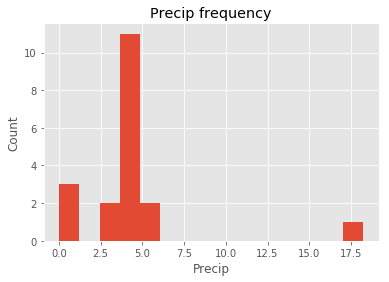

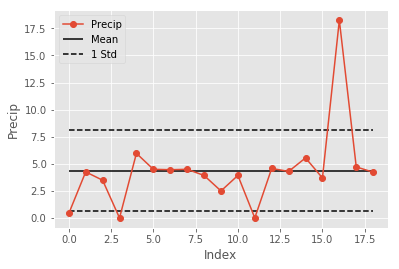

In [52]:
_plot_(dugway_ex_dpg04_df['ACCUM_226_DAYS'])

In [53]:
# compute chebyshev bound for dpg04
# stid filter 
dpg04_filter = dugway_ex_dpg04_df['STID'] == 'DPG04'
total_precip = np.array(dugway_ex_dpg04_df.filter(regex='ACCUM.*')[~dpg04_filter])
mu = total_precip.mean()
var = total_precip.var()
print('Mean: ', mu)
print('Variance: ', var)
print('Std Dev: ', var**.5)

dugway_dpg04_bound_col = np.full(dugway_ex_dpg04_df.shape[0], np.nan, dtype='float')

for i, row in dugway_ex_dpg04_df[dpg04_filter].iterrows():
    alpha = row.filter(regex='ACCUM.*').values
    epsilon = alpha-mu
    bound = var/(epsilon**2)
    dugway_dpg04_bound_col[i] = bound
    
# make new colum
dugway_ex_dpg04_df['CHEBY_BOUND'] = dugway_dpg04_bound_col

# filter out the ones we actually computed
dugway_ex_dpg04_df[~dugway_ex_dpg04_df['CHEBY_BOUND'].isna()]

Mean:  4.618333333333333
Variance:  13.091547222222223
Std Dev:  3.618224318947379


,DISTANCE,ELEVATION,ELEV_DEM,ID,LATITUDE,LONGITUDE,MNET_ID,NAME,RESTRICTED,STATE,STATUS,STID,TIMEZONE,ACCUM_226_DAYS,EPOCH_TIMEDELTA,COUNT,CHEBY_BOUND
3,0.0,4349,4370.1,451,40.04602,-113.0455,3,TARGET S,False,UT,ACTIVE,DPG04,America/Denver,0.0,19613100,59879,0.613791


As we can see we did not get a very low bound for either case although the first is fairly low. The reason for this is that the dataset is contaminated by other outliers. Next we will develop some method to deal with this because it happens all too often.

## Dealing with contamination
It is likely that every data set has some contamination. By contamination we don't mean noise. Because noise in the data is inherent to the way it is collected, i.e. the different sensor accuracies. Contamination here means a set of points in the data that is "contaminating" the overall data set by introducing an unwanted bias. This makes identifying outliers difficult because as we've seen above the detection failed because there is more than one outlier.

Here are several ideas to deal with this contamination which we will go over:
1. Ignore it.
2. Leave one out.
3. Amplify outliers.
4. Weighted average based on distance

#### Ignore It
This isn't as crazy as it seems. In our analysis we certainly do not want to classify a stations as mis-reporting if it isn't miss reporting. In other words we want the algorithm to be conservative if anything. Ignoring the contamination will result in less false positives. However, over time as we filter outliers out of the datasets we are looking at the contaminators could be the only outliers left depending on the situation.

#### Leave One out
We can also algorithmically leave every data point out and recalculate the bound each time. The point that we take out the increases/decreases the bound the most is a contaminating point. The issue is defining a good amount of increase/decrease of the bound that is meaningful.

#### Amplify Outliers or Weighted Average
These two approaches are very similar. In one case we are actually transforming the data and computing its mean. In the other case we are modifying the mean to better represent the data. Either of these approaches seem to be the best for this contamination problem.

To amplify the outliers we would need to come up with a function to transform the data that makes the outlying data points larger. this only works to a certain point. If our average accumulated precipitation is 3 inches and we have one outlier at 0 inches we can't amplify it any further beyond zero.

The weighted average will work well to model the proximity relationship of our data if it is based on the distance. However there comes yet another hurdle. If the nearby stations are also outliers the we actually introduce a bias into the mean towards the outlier. 

#### Conclusion
So we need some sort of combination of these to get the results we would like. In the end we will use many different heuristics to find these outliers and build a score based on many different statistics. e.g. the Cheby-Chev bound. Some things we can include are the Mahalanobis distance which we've looked at before. Or a PCA dimension reduction that will reveal outliers after clustering, Kernal density clas